In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import plot_importance

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pickle
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')

## DATA LOADING AND PREPROCESSING

In [ ]:
print("="*80)
print("DATA LOADING AND PREPROCESSING")
print("="*80 + "\n")

# Load air quality dataset
air_quality_filepath = 'london_air_quality_2013_2025.csv'
df = pd.read_csv(air_quality_filepath)

print(f"Dataset loaded successfully from: {air_quality_filepath}")
print(f"Total records: {df.shape[0]} | Features: {df.shape[1]}")

DATA LOADING AND PREPROCESSING

Dataset loaded successfully from: london_air_quality_2013_2025.csv
Total records: 4566 | Features: 8


In [ ]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print("Date column converted to datetime format")

# Set date as index and sort chronologically
df = df.set_index('date')
df = df.sort_index()
print("Data sorted chronologically")

Date column converted to datetime format
Data sorted chronologically


In [ ]:
# Identify pollutant features
pollutant_features = ['pm10', 'pm25', 'co', 'no2', 'so2', 'o3', 'dust']

print(f"\nMissing values before imputation:")
print(df[pollutant_features].isnull().sum())

# Apply mean imputation for missing values
df[pollutant_features] = df[pollutant_features].fillna(df[pollutant_features].mean())
print(f"\nMissing values imputed using mean")

# Clip negative values (no negative pollution levels should exist)
for col in pollutant_features:
    df[col] = df[col].clip(lower=0)
print("Negative values clipped to zero")


Missing values before imputation:
pm10       0
pm25       0
co      1005
no2        0
so2     1005
o3         0
dust    1736
dtype: int64

Missing values imputed using mean
Negative values clipped to zero


In [ ]:
# Convert CO from µg/m³ to ppm (1 ppm = 1145 µg/m³)
if 'co' in df.columns:
    df['co'] = df['co'] / 1145
    print("Converted CO from µg/m³ to ppm")

print("\nPollutant value ranges (min–max):")
for col in pollutant_features:
    print(f"  {col.upper()}: {df[col].min():.3f} – {df[col].max():.3f}")

Converted CO from µg/m³ to ppm

Pollutant value ranges (min–max):
  PM10: 3.375 – 85.067
  PM25: 1.708 – 78.729
  CO: 0.075 – 0.678
  NO2: 4.342 – 110.021
  SO2: 0.492 – 15.854
  O3: 0.792 – 111.625
  DUST: 0.000 – 29.500


In [ ]:
# Focus on PM2.5 for forecasting
pm25_df = df[['pm25']].copy()
print(f"\nExtracted PM2.5 for time series forecasting")
print(f"Date range: {pm25_df.index.min()} to {pm25_df.index.max()}")
print(f"Total samples: {len(pm25_df)}")

print("\nPM2.5 Statistics:")
print(pm25_df['pm25'].describe())


Extracted PM2.5 for time series forecasting
Date range: 2013-04-01 00:00:00 to 2025-09-30 00:00:00
Total samples: 4566

PM2.5 Statistics:
count    4566.000000
mean       10.769742
std         7.211292
min         1.708333
25%         6.209375
50%         8.295833
75%        12.661458
max        78.729167
Name: pm25, dtype: float64


## EXPLORATORY DATA ANALYSIS (EDA)

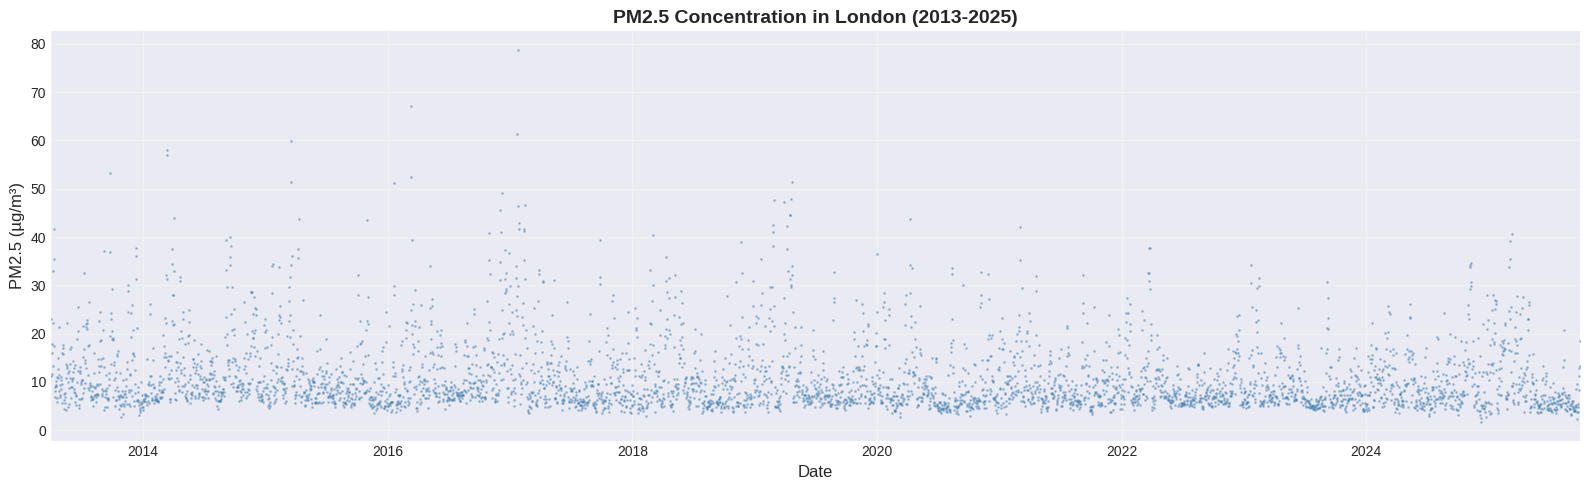

In [ ]:
# Visualization 1: PM2.5 Full Time Series
fig, ax = plt.subplots(figsize=(16, 5))
pm25_df['pm25'].plot(ax=ax, style='.', color='steelblue', alpha=0.4, markersize=2)
ax.set_title('PM2.5 Concentration in London (2013-2025)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

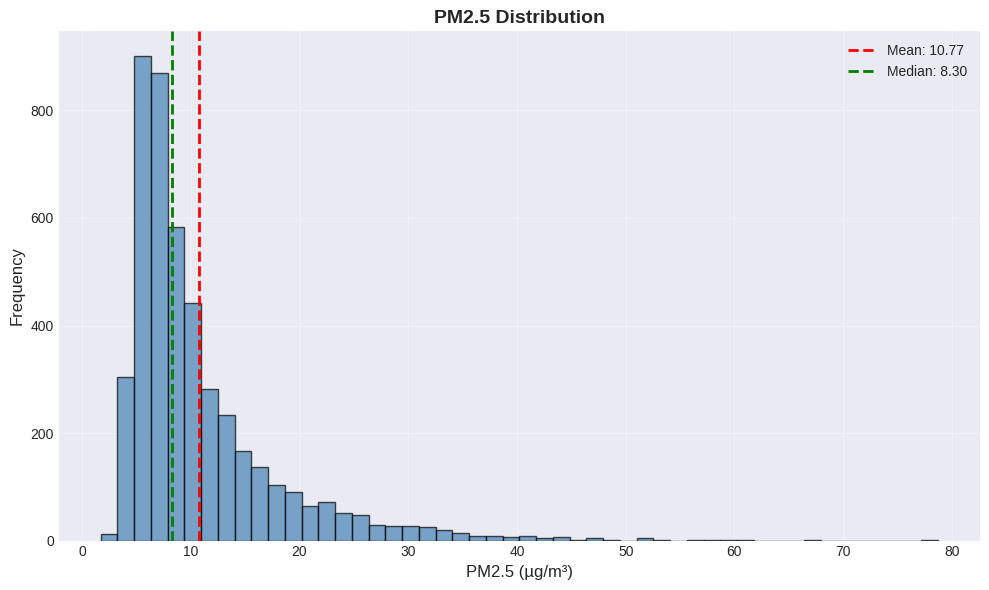

In [ ]:
# Visualization 2: PM2.5 Distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(pm25_df['pm25'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_title('PM2.5 Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('PM2.5 (µg/m³)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.axvline(pm25_df['pm25'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {pm25_df["pm25"].mean():.2f}')
ax.axvline(pm25_df['pm25'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {pm25_df["pm25"].median():.2f}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

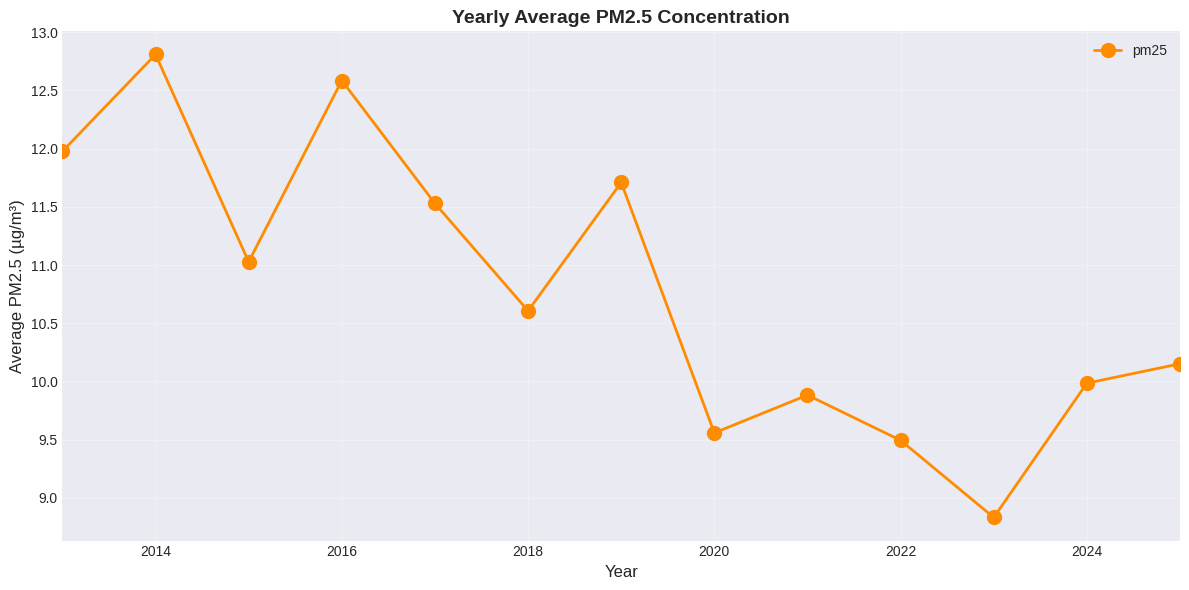

In [ ]:
# Visualization 3: Yearly PM2.5 Trends
pm25_yearly = pm25_df.resample('Y').mean()
fig, ax = plt.subplots(figsize=(12, 6))
pm25_yearly.plot(ax=ax, marker='o', markersize=10, linewidth=2, color='darkorange')
ax.set_title('Yearly Average PM2.5 Concentration', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Average PM2.5 (µg/m³)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

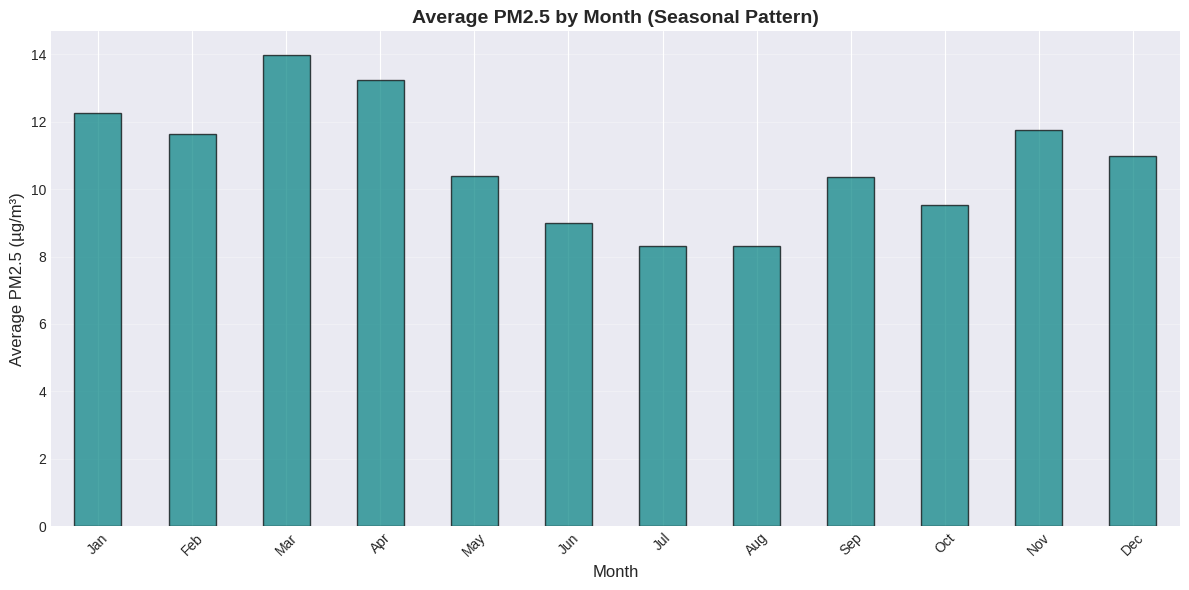

In [ ]:
# Visualization 4: Monthly Average Pattern
pm25_df_temp = pm25_df.copy()
pm25_df_temp['month'] = pm25_df_temp.index.month
monthly_avg = pm25_df_temp.groupby('month')['pm25'].mean()

fig, ax = plt.subplots(figsize=(12, 6))
monthly_avg.plot(ax=ax, kind='bar', color='teal', edgecolor='black', alpha=0.7)
ax.set_title('Average PM2.5 by Month (Seasonal Pattern)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average PM2.5 (µg/m³)', fontsize=12)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## TEMPORAL TRAIN/TEST SPLIT

Training set: 2013-04-01 00:00:00 to 2021-12-31 00:00:00 (3197 samples)
Testing set:  2022-01-01 00:00:00 to 2025-09-30 00:00:00 (1369 samples)
Split ratio: 70.0% train / 30.0% test


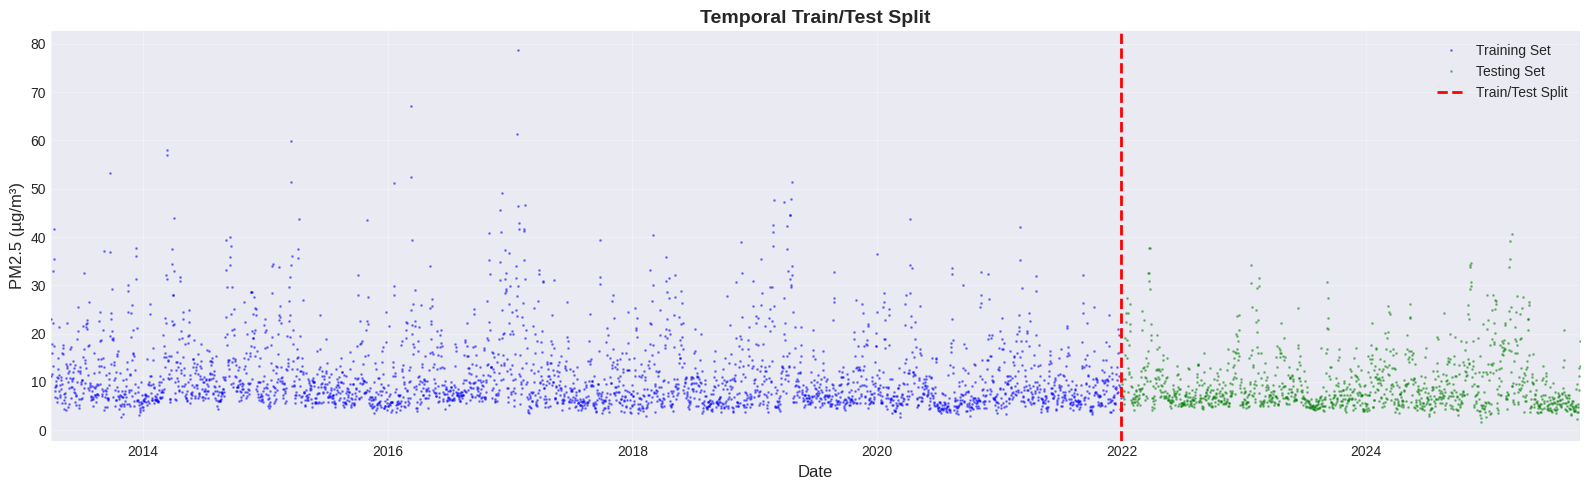

In [ ]:
# Split date: Train on 2013-2021, Test on 2022-2025
split_date = '2021-12-31'

train = pm25_df.loc[pm25_df.index <= split_date].copy()
test = pm25_df.loc[pm25_df.index > split_date].copy()

print(f"Training set: {train.index.min()} to {train.index.max()} ({len(train)} samples)")
print(f"Testing set:  {test.index.min()} to {test.index.max()} ({len(test)} samples)")
print(f"Split ratio: {len(train)/(len(train)+len(test))*100:.1f}% train / {len(test)/(len(train)+len(test))*100:.1f}% test")

# Visualize train/test split
fig, ax = plt.subplots(figsize=(16, 5))
train['pm25'].plot(ax=ax, label='Training Set', style='.', alpha=0.4, markersize=2, color='blue')
test['pm25'].plot(ax=ax, label='Testing Set', style='.', alpha=0.4, markersize=2, color='green')
ax.axvline(pd.to_datetime(split_date), color='red', linestyle='--', linewidth=2, label='Train/Test Split')
ax.set_title('Temporal Train/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## FEATURE ENGINEERING (TIME-BASED FEATURES)

In [ ]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    return df

train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']
TARGET = 'pm25'

print("Time-based features created:")
print(f"  Features: {FEATURES}")
print(f"  Target: {TARGET}\n")

Time-based features created:
  Features: ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
  Target: pm25



## MODEL 1: LSTM

In [ ]:
# Prepare data for LSTM
scaler_lstm = StandardScaler()
scaler_lstm.fit(train[['pm25']])

train_scaled = scaler_lstm.transform(train[['pm25']])
test_scaled = scaler_lstm.transform(test[['pm25']])

# Create sequences for LSTM
def create_sequences(data, seq_length=7):
    """
    Create sequences for LSTM input
    seq_length: number of past days to use for prediction
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
print(f"Creating sequences with lookback window: {SEQ_LENGTH} days")

X_train_lstm, y_train_lstm = create_sequences(train_scaled, SEQ_LENGTH)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, SEQ_LENGTH)

# Reshape for LSTM [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

print(f"Training sequences shape: {X_train_lstm.shape}")
print(f"Testing sequences shape: {X_test_lstm.shape}")

Creating sequences with lookback window: 30 days
Training sequences shape: (3167, 30, 1)
Testing sequences shape: (1339, 30, 1)


In [ ]:
# Build LSTM model
print("\nBuilding LSTM model...")

lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh'), input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print("\nLSTM Model Architecture:")
lstm_model.summary()


Building LSTM model...

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,841 (1.17 MB)

 Trainable params: 307,841 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train LSTM
print("\nTraining LSTM model...")

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n LSTM training completed!")


Training LSTM model...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.8962 - mae: 0.6565 - val_loss: 0.4534 - val_mae: 0.4877 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7019 - mae: 0.5626 - val_loss: 0.3691 - val_mae: 0.4404 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5765 - mae: 0.5103 - val_loss: 0.3705 - val_mae: 0.4232 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5533 - mae: 0.5064 - val_loss: 0.3758 - val_mae: 0.4260 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5279 - mae: 0.4864 - val_loss: 0.3386 - val_mae: 0.4074 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5645 - mae: 0.5000 - val_loss: 0.3468 - val_mae: 0.4135 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5118 - mae: 0.4918 - val_loss: 0.3421 - val_mae: 0.4155 - learning_ra

In [ ]:
# Predictions
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm, verbose=0)
y_pred_lstm = scaler_lstm.inverse_transform(y_pred_lstm_scaled)
y_test_lstm_actual = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))

# Calculate metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm_actual, y_pred_lstm))
lstm_mae = mean_absolute_error(y_test_lstm_actual, y_pred_lstm)
lstm_mape = np.mean(np.abs((y_test_lstm_actual - y_pred_lstm) / y_test_lstm_actual)) * 100
lstm_r2 = r2_score(y_test_lstm_actual, y_pred_lstm)

print(f"\nLSTM Performance on Test Set:")
print(f"  RMSE: {lstm_rmse:.4f}")
print(f"  MAE:  {lstm_mae:.4f}")
print(f"  MAPE: {lstm_mape:.2f}%")
print(f"  R²:   {lstm_r2:.4f}")


LSTM Performance on Test Set:
  RMSE: 4.0303
  MAE:  2.9267
  MAPE: 36.15%
  R²:   0.5010


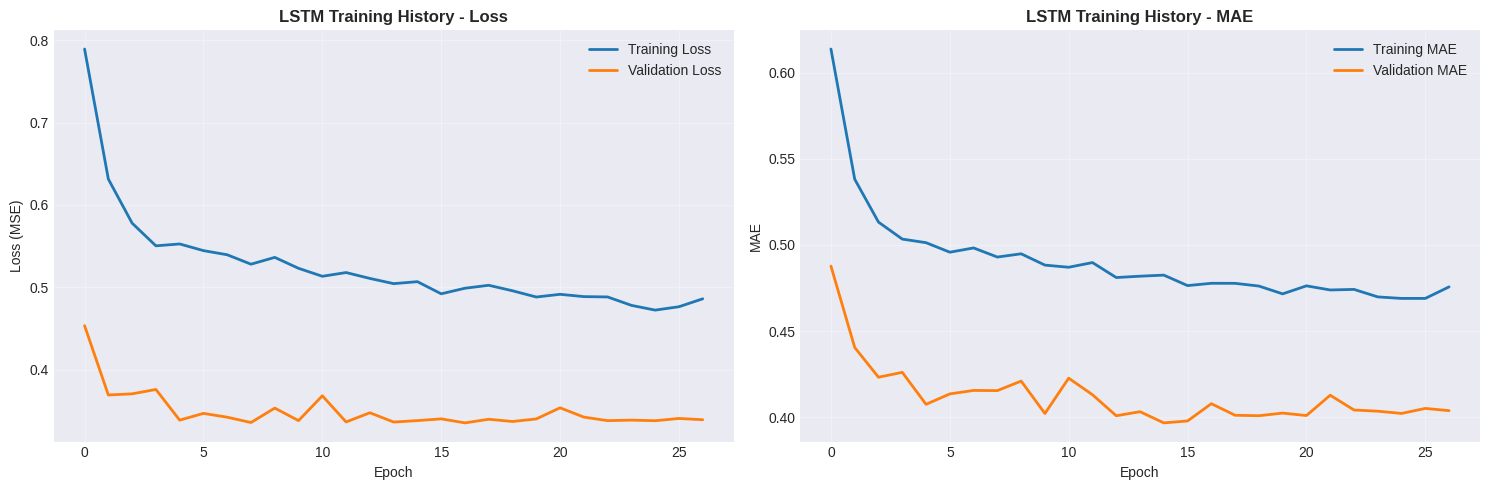

In [ ]:
# Save predictions to test dataframe
test_lstm = test.iloc[SEQ_LENGTH:].copy()
test_lstm['pm25_pred_lstm'] = y_pred_lstm

# Training history plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('LSTM Training History - Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('LSTM Training History - MAE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save LSTM model
lstm_model.save('lstm_pm25_model.keras')

## MODEL 2: XGBOOST

In [ ]:
X_train_xgb = train[FEATURES]
y_train_xgb = train[TARGET]
X_test_xgb = test[FEATURES]
y_test_xgb = test[TARGET]

# Baseline XGBoost
print("Training baseline XGBoost model...")
baseline_xgb = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    random_state=5303
)

baseline_xgb.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)],
    verbose=False
)

y_pred_baseline = baseline_xgb.predict(X_test_xgb)
baseline_rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_baseline))
baseline_mae = mean_absolute_error(y_test_xgb, y_pred_baseline)

print(f"Baseline XGBoost RMSE: {baseline_rmse:.4f}")
print(f"Baseline XGBoost MAE:  {baseline_mae:.4f}")

Training baseline XGBoost model...
Baseline XGBoost RMSE: 5.7301
Baseline XGBoost MAE:  4.4460


In [ ]:
# Hyperparameter tuning
print("\nHyperparameter tuning with RandomizedSearchCV...")

param_dist = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3]
}

xgb_model = xgb.XGBRegressor(random_state=5303)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=5303,
    n_jobs=-1
)

random_search.fit(X_train_xgb, y_train_xgb)

print("\n Hyperparameter tuning completed!")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Optimized XGBoost
optimized_xgb = random_search.best_estimator_

y_pred_xgb = optimized_xgb.predict(X_test_xgb)

xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
xgb_mae = mean_absolute_error(y_test_xgb, y_pred_xgb)
xgb_mape = np.mean(np.abs((y_test_xgb - y_pred_xgb) / y_test_xgb)) * 100
xgb_r2 = r2_score(y_test_xgb, y_pred_xgb)

print(f"\nOptimized XGBoost Performance on Test Set:")
print(f"  RMSE: {xgb_rmse:.4f}")
print(f"  MAE:  {xgb_mae:.4f}")
print(f"  MAPE: {xgb_mape:.2f}%")
print(f"  R²:   {xgb_r2:.4f}")

print(f"\nImprovement over baseline:")
print(f"  RMSE: {baseline_rmse:.4f} → {xgb_rmse:.4f} ({((baseline_rmse-xgb_rmse)/baseline_rmse*100):.2f}% better)")
print(f"  MAE:  {baseline_mae:.4f} → {xgb_mae:.4f} ({((baseline_mae-xgb_mae)/baseline_mae*100):.2f}% better)")

test['pm25_pred_xgb'] = y_pred_xgb


Hyperparameter tuning with RandomizedSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Hyperparameter tuning completed!

Best Parameters:
  subsample: 0.8
  n_estimators: 500
  min_child_weight: 1
  max_depth: 3
  learning_rate: 0.01
  gamma: 0
  colsample_bytree: 0.6

Optimized XGBoost Performance on Test Set:
  RMSE: 5.5817
  MAE:  4.1502
  MAPE: 50.62%
  R²:   0.0620

Improvement over baseline:
  RMSE: 5.7301 → 5.5817 (2.59% better)
  MAE:  4.4460 → 4.1502 (6.65% better)


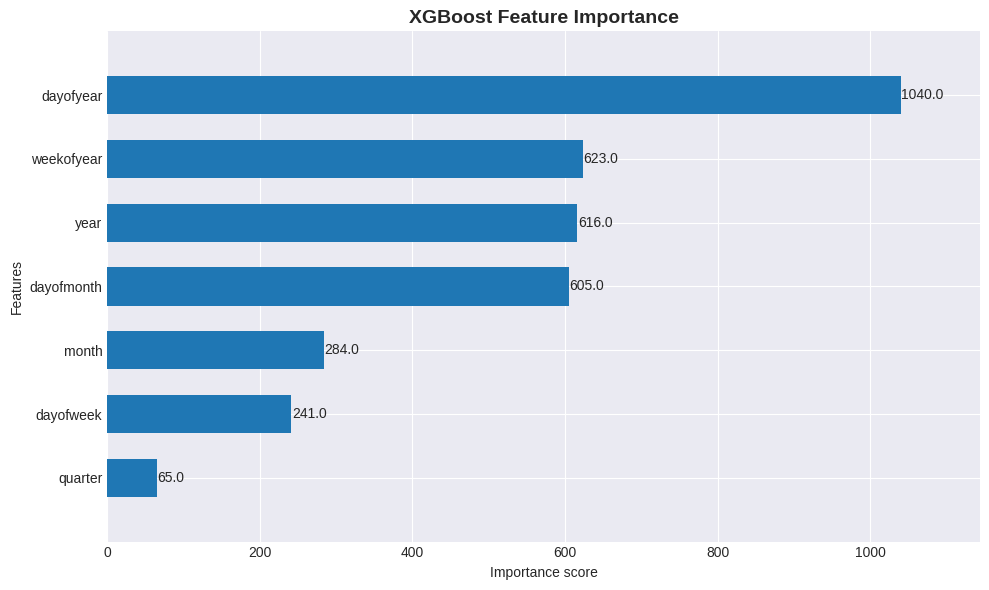

In [ ]:
# Feature importance
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(optimized_xgb, ax=ax, height=0.6)
ax.set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# MODEL 3: SVM

In [ ]:
# Scale features for SVM
scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train_xgb)
X_test_svm_scaled = scaler_svm.transform(X_test_xgb)

# Baseline SVM
print("Training baseline SVM model...")
baseline_svm = SVR(kernel='rbf')
baseline_svm.fit(X_train_svm_scaled, y_train_xgb)

y_pred_baseline_svm = baseline_svm.predict(X_test_svm_scaled)
baseline_svm_rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_baseline_svm))
baseline_svm_mae = mean_absolute_error(y_test_xgb, y_pred_baseline_svm)

print(f"Baseline SVM RMSE: {baseline_svm_rmse:.4f}")
print(f"Baseline SVM MAE:  {baseline_svm_mae:.4f}")

# Hyperparameter tuning for SVM
print("\nHyperparameter tuning for SVM...")
print("This may take several minutes...\n")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

svm_model = SVR(kernel='rbf')

grid_search = GridSearchCV(
    svm_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_svm_scaled, y_train_xgb)

print("\n SVM hyperparameter tuning completed!")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Optimized SVM
optimized_svm = grid_search.best_estimator_

y_pred_svm = optimized_svm.predict(X_test_svm_scaled)

svm_rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_svm))
svm_mae = mean_absolute_error(y_test_xgb, y_pred_svm)
svm_mape = np.mean(np.abs((y_test_xgb - y_pred_svm) / y_test_xgb)) * 100
svm_r2 = r2_score(y_test_xgb, y_pred_svm)

print(f"\nOptimized SVM Performance on Test Set:")
print(f"  RMSE: {svm_rmse:.4f}")
print(f"  MAE:  {svm_mae:.4f}")
print(f"  MAPE: {svm_mape:.2f}%")
print(f"  R²:   {svm_r2:.4f}")

print(f"\nImprovement over baseline:")
print(f"  RMSE: {baseline_svm_rmse:.4f} → {svm_rmse:.4f} ({((baseline_svm_rmse-svm_rmse)/baseline_svm_rmse*100):.2f}% better)")
print(f"  MAE:  {baseline_svm_mae:.4f} → {svm_mae:.4f} ({((baseline_svm_mae-svm_mae)/baseline_svm_mae*100):.2f}% better)")

test['pm25_pred_svm'] = y_pred_svm

# Save SVM model and scaler
with open('svm_pm25_model.pkl', 'wb') as f:
    pickle.dump(optimized_svm, f)
with open('svm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_svm, f)

Training baseline SVM model...
Baseline SVM RMSE: 5.9729
Baseline SVM MAE:  3.8256

Hyperparameter tuning for SVM...
This may take several minutes...

Fitting 5 folds for each of 80 candidates, totalling 400 fits

 SVM hyperparameter tuning completed!

Best Parameters:
  C: 1
  epsilon: 0.5
  gamma: auto

Optimized SVM Performance on Test Set:
  RMSE: 5.9266
  MAE:  3.8029
  MAPE: 37.39%
  R²:   -0.0575

Improvement over baseline:
  RMSE: 5.9729 → 5.9266 (0.78% better)
  MAE:  3.8256 → 3.8029 (0.60% better)


# MODEL COMPARISON

Model Performance Comparison:
  Model     RMSE      MAE      MAPE        R²
   LSTM 4.030336 2.926685 36.153412  0.500978
XGBoost 5.581657 4.150212 50.622423  0.062000
    SVM 5.926583 3.802863 37.391614 -0.057512

Best Performing Model: LSTM (RMSE: 4.0303)



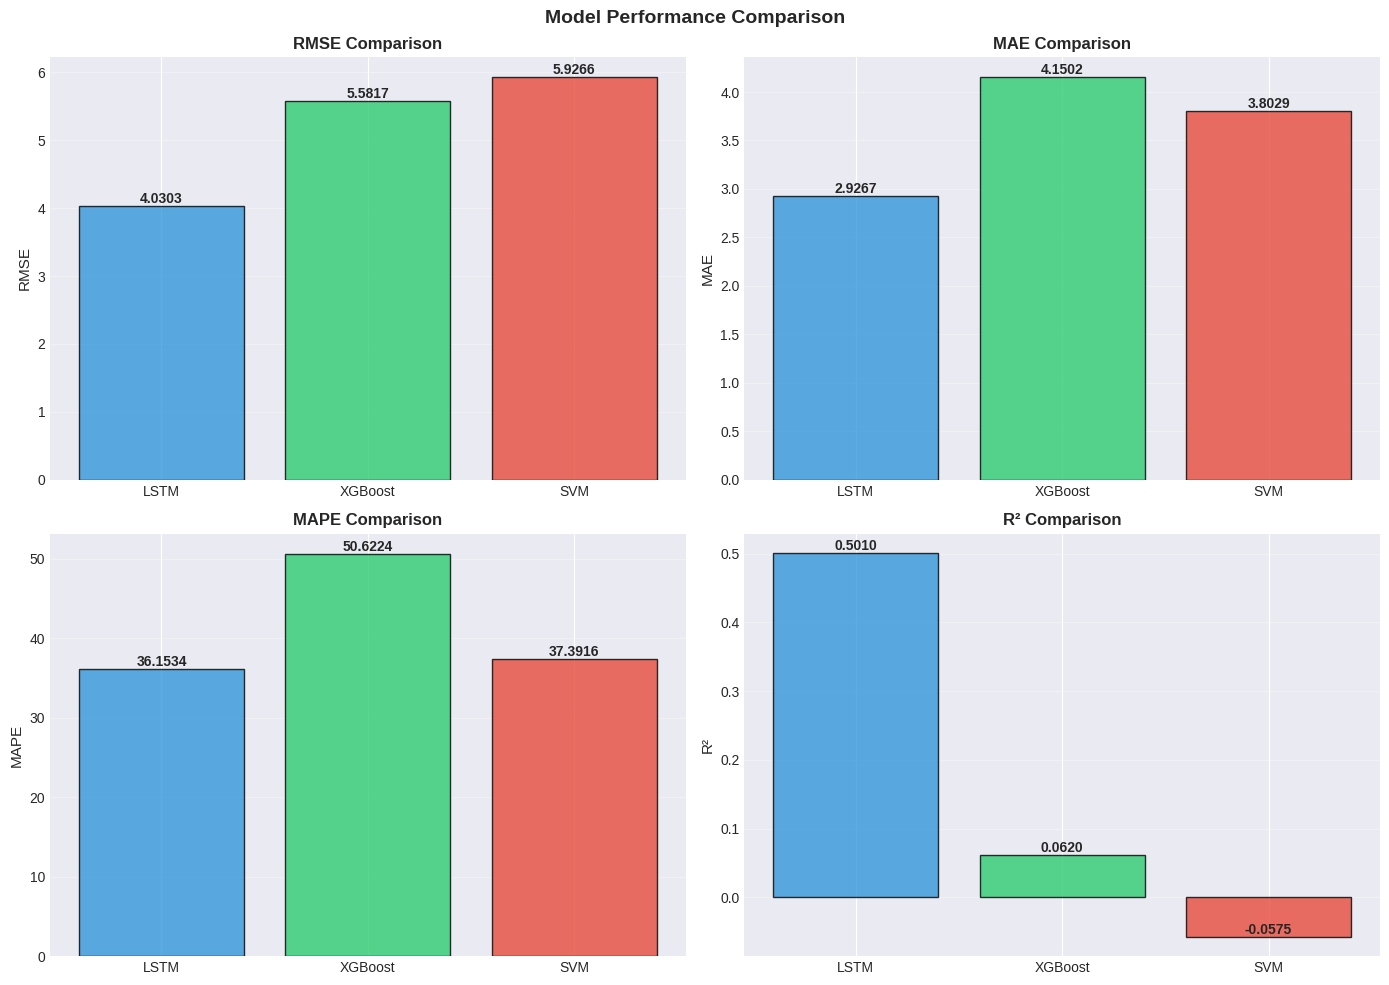

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'XGBoost', 'SVM'],
    'RMSE': [lstm_rmse, xgb_rmse, svm_rmse],
    'MAE': [lstm_mae, xgb_mae, svm_mae],
    'MAPE': [lstm_mape, xgb_mape, svm_mape],
    'R²': [lstm_r2, xgb_r2, svm_r2]
})

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))
print()

# Find best model
best_model_idx = comparison_df['RMSE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_rmse = comparison_df.loc[best_model_idx, 'RMSE']

print(f"Best Performing Model: {best_model_name} (RMSE: {best_rmse:.4f})\n")

# Visualization 1: Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

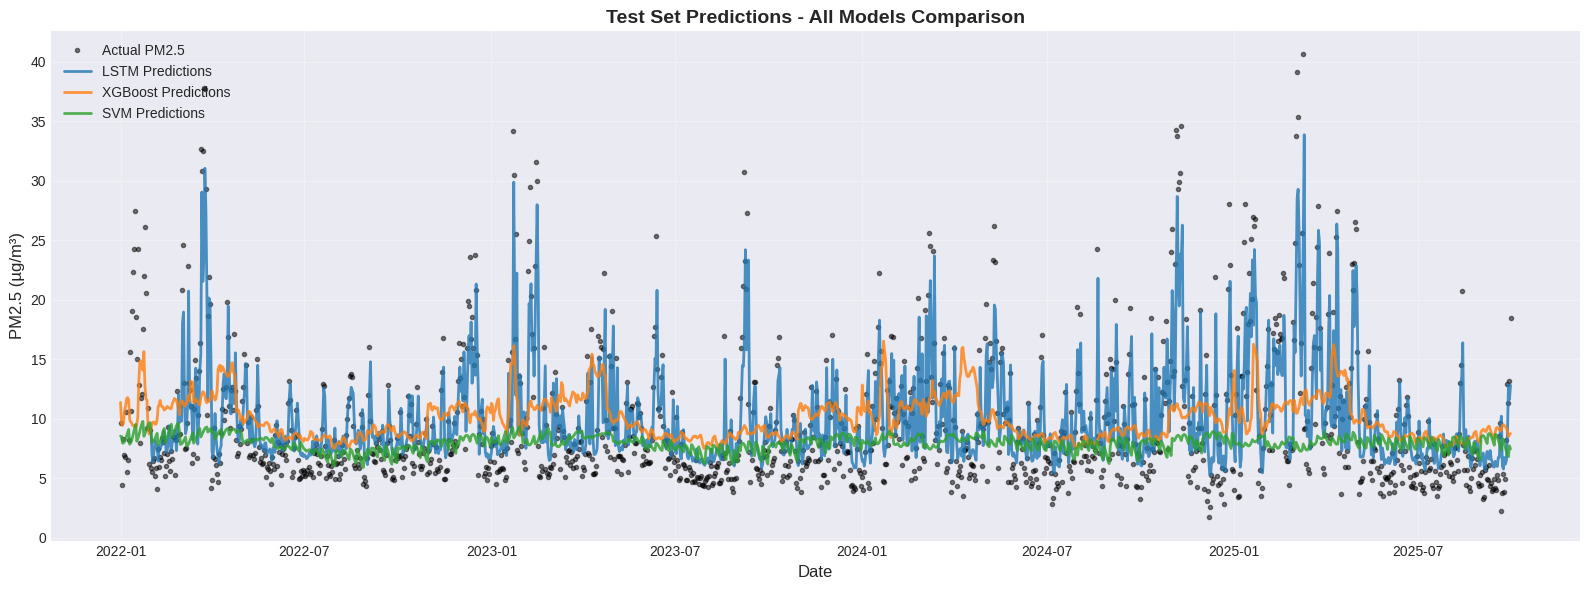

In [ ]:
# Visualization 2: Test Predictions Comparison
fig, ax = plt.subplots(figsize=(16, 6))

# Align all predictions
test_aligned = test.copy()
# For LSTM, we need to align (it has fewer samples due to sequences)
test_lstm_aligned = test_aligned.loc[test_lstm.index]

ax.plot(test_aligned.index, test_aligned['pm25'], 'o', label='Actual PM2.5',
        alpha=0.5, markersize=3, color='black')
ax.plot(test_lstm_aligned.index, test_lstm['pm25_pred_lstm'], '-',
        label='LSTM Predictions', linewidth=2, alpha=0.8)
ax.plot(test_aligned.index, test_aligned['pm25_pred_xgb'], '-',
        label='XGBoost Predictions', linewidth=2, alpha=0.8)
ax.plot(test_aligned.index, test_aligned['pm25_pred_svm'], '-',
        label='SVM Predictions', linewidth=2, alpha=0.8)

ax.set_title('Test Set Predictions - All Models Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

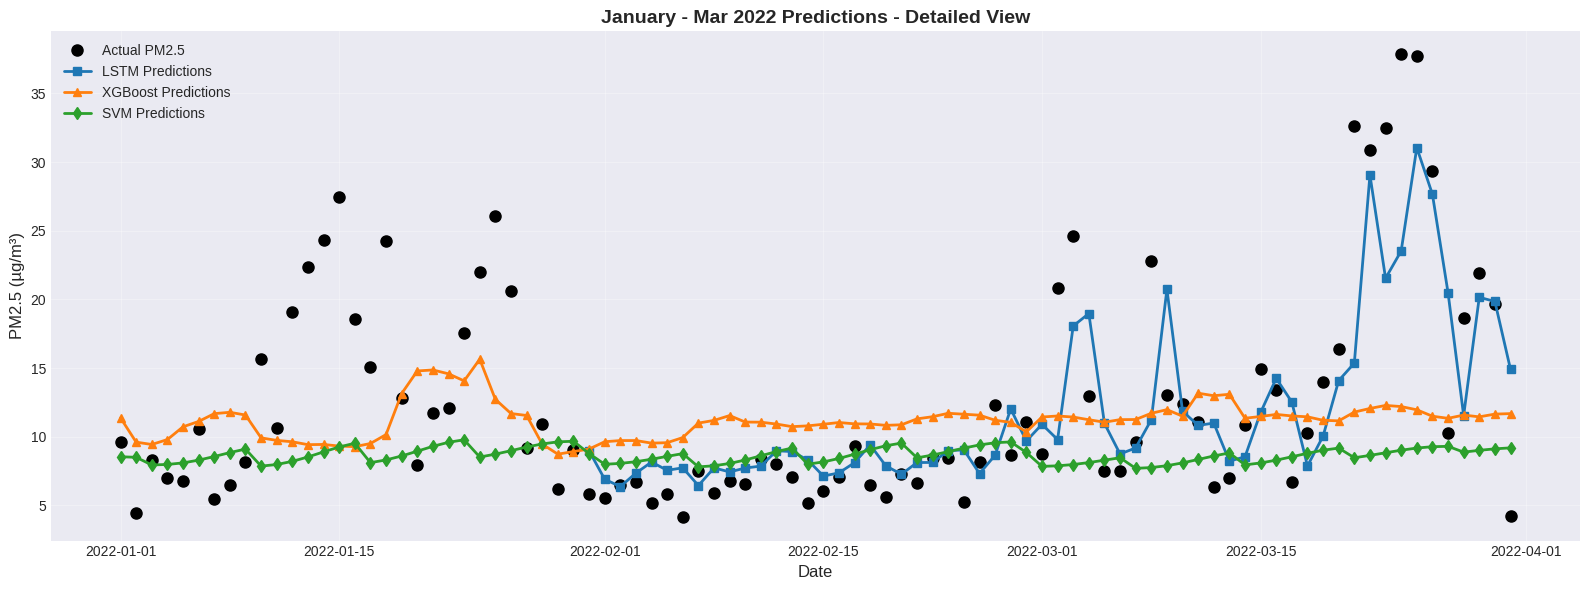

In [ ]:
test_lstm_aligned = test.loc[test_lstm.index].copy()
test_lstm_aligned['pm25_pred_lstm'] = test_lstm['pm25_pred_lstm']

# Subset January
test_jan = test.loc['2022-01-01':'2022-03-31']
test_lstm_jan = test_lstm_aligned.loc['2022-01-01':'2022-03-31']

# Plot
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(test_jan.index, test_jan['pm25'], 'o', label='Actual PM2.5',
        markersize=8, color='black')
ax.plot(test_lstm_jan.index, test_lstm_jan['pm25_pred_lstm'], 's-',
        label='LSTM Predictions', linewidth=2, markersize=6)
ax.plot(test_jan.index, test_jan['pm25_pred_xgb'], '^-',
        label='XGBoost Predictions', linewidth=2, markersize=6)
ax.plot(test_jan.index, test_jan['pm25_pred_svm'], 'd-',
        label='SVM Predictions', linewidth=2, markersize=6)

ax.set_title('January - Mar 2022 Predictions - Detailed View', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



FUTURE FORECASTING (2026-2030)

Generating XGBoost future forecast...
Generating SVM future forecast...
Generating LSTM future forecast...
(This uses recursive prediction from last known values)

Future forecasts generated for 1826 days
Forecast range: 2026-01-01 00:00:00 to 2030-12-31 00:00:00

Future Forecast Statistics (2026-2030):

LSTM:
count    1826.000000
mean       13.111624
std         0.169906
min        10.906971
25%        13.109265
50%        13.109265
75%        13.109265
max        15.867634
Name: pm25_lstm, dtype: float64

XGBoost:
count    1826.000000
mean        9.983438
std         1.687713
min         7.503153
25%         8.620430
50%         9.568927
75%        11.030782
max        16.524950
Name: pm25_xgb, dtype: float64

SVM:
count    1826.000000
mean        8.240046
std         0.425031
min         6.935695
25%         7.919041
50%         8.239875
75%         8.595776
max         9.113970
Name: pm25_svm, dtype: float64


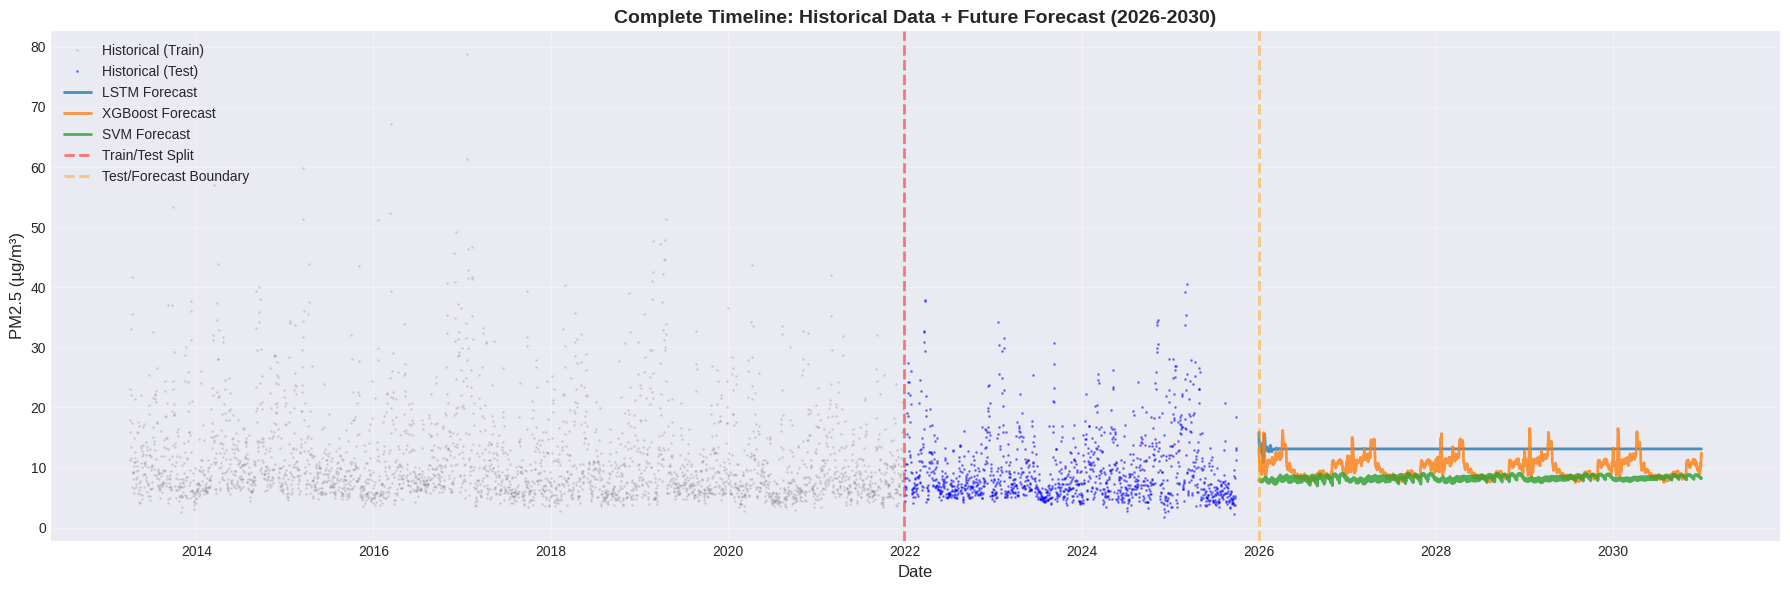

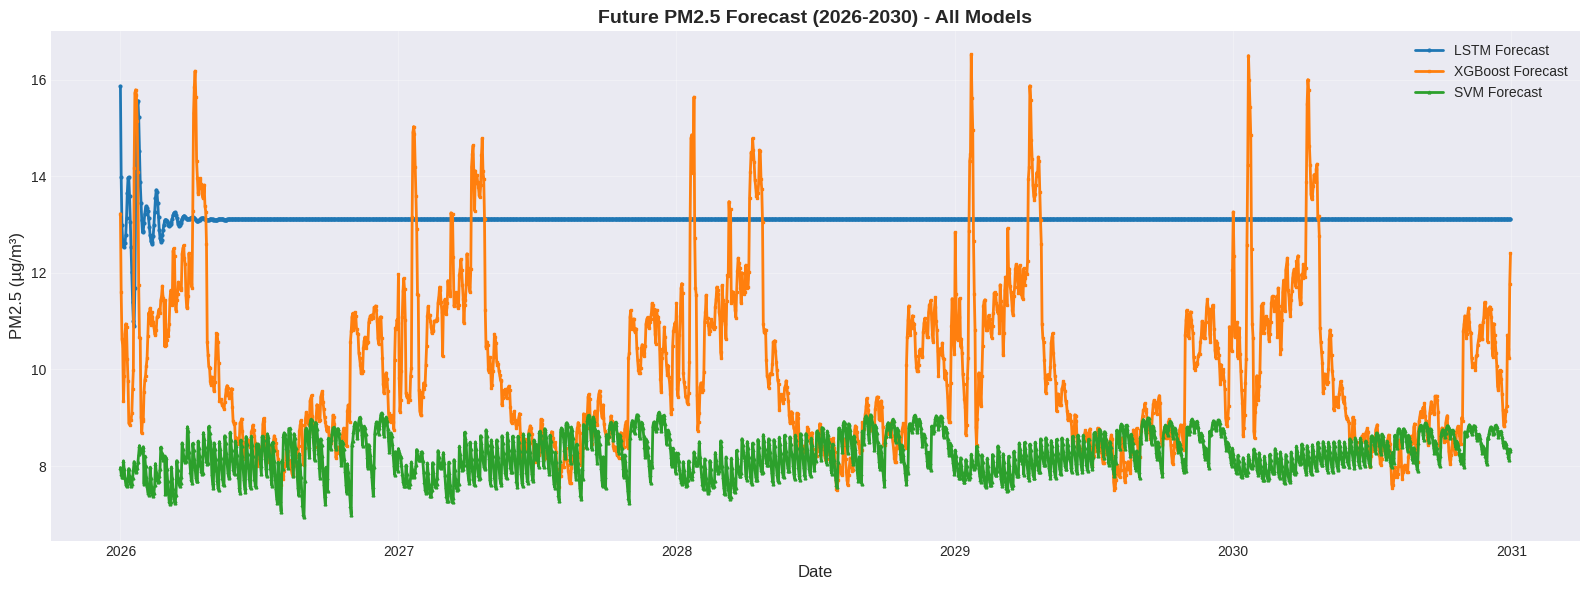

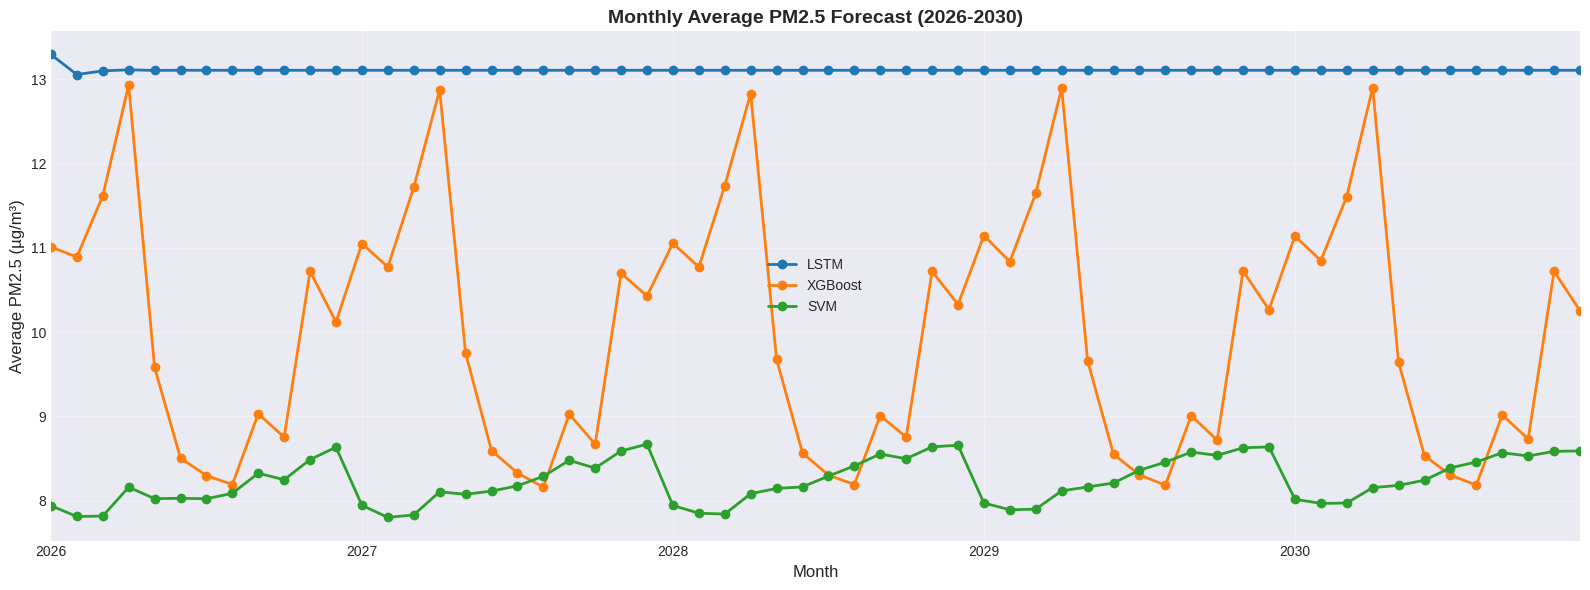

In [ ]:
# FUTURE FORECASTING (2026-2030)
print(f"\n{'='*80}")
print("FUTURE FORECASTING (2026-2030)")
print("="*80 + "\n")

# Create future dates
future_dates = pd.date_range(start='2026-01-01', end='2030-12-31', freq='D')
future_df = pd.DataFrame(index=future_dates)
future_df.index.name = 'date'

# Create features for future dates
future_df = create_features(pd.DataFrame({'pm25': np.nan}, index=future_dates))

# XGBoost Future Forecast
print("Generating XGBoost future forecast...")
X_future = future_df[FEATURES]
future_df['pm25_xgb'] = optimized_xgb.predict(X_future)

# SVM Future Forecast
print("Generating SVM future forecast...")
X_future_scaled = scaler_svm.transform(X_future)
future_df['pm25_svm'] = optimized_svm.predict(X_future_scaled)

# LSTM Future Forecast (recursive prediction)
print("Generating LSTM future forecast...")
print("(This uses recursive prediction from last known values)")

# Get last sequence from test data
last_sequence = test_scaled[-SEQ_LENGTH:]
lstm_future_predictions = []

for i in range(len(future_dates)):
    # Reshape for prediction
    current_seq = last_sequence.reshape(1, SEQ_LENGTH, 1)

    # Predict next value
    next_pred = lstm_model.predict(current_seq, verbose=0)[0, 0]
    lstm_future_predictions.append(next_pred)

    # Update sequence (remove first, add predicted)
    last_sequence = np.append(last_sequence[1:], next_pred)

# Inverse transform
lstm_future_predictions = scaler_lstm.inverse_transform(
    np.array(lstm_future_predictions).reshape(-1, 1)
)
future_df['pm25_lstm'] = lstm_future_predictions

print(f"\nFuture forecasts generated for {len(future_df)} days")
print(f"Forecast range: {future_df.index.min()} to {future_df.index.max()}")

print("\nFuture Forecast Statistics (2026-2030):")
print("\nLSTM:")
print(future_df['pm25_lstm'].describe())
print("\nXGBoost:")
print(future_df['pm25_xgb'].describe())
print("\nSVM:")
print(future_df['pm25_svm'].describe())

# Visualization: Complete Timeline
fig, ax = plt.subplots(figsize=(18, 6))

# Historical data
ax.plot(train.index, train['pm25'], '.', label='Historical (Train)',
        alpha=0.2, markersize=2, color='gray')
ax.plot(test.index, test['pm25'], '.', label='Historical (Test)',
        alpha=0.4, markersize=2, color='blue')

# Future forecasts
ax.plot(future_df.index, future_df['pm25_lstm'], '-',
        label='LSTM Forecast', linewidth=2, alpha=0.8)
ax.plot(future_df.index, future_df['pm25_xgb'], '-',
        label='XGBoost Forecast', linewidth=2, alpha=0.8)
ax.plot(future_df.index, future_df['pm25_svm'], '-',
        label='SVM Forecast', linewidth=2, alpha=0.8)

ax.axvline(pd.to_datetime(split_date), color='red', linestyle='--',
           linewidth=2, alpha=0.5, label='Train/Test Split')
ax.axvline(pd.to_datetime('2025-12-31'), color='orange', linestyle='--',
           linewidth=2, alpha=0.5, label='Test/Forecast Boundary')

ax.set_title('Complete Timeline: Historical Data + Future Forecast (2026-2030)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Zoom into future forecast only
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(future_df.index, future_df['pm25_lstm'], '-',
        label='LSTM Forecast', linewidth=2, marker='o', markersize=2)
ax.plot(future_df.index, future_df['pm25_xgb'], '-',
        label='XGBoost Forecast', linewidth=2, marker='s', markersize=2)
ax.plot(future_df.index, future_df['pm25_svm'], '-',
        label='SVM Forecast', linewidth=2, marker='^', markersize=2)

ax.set_title('Future PM2.5 Forecast (2026-2030) - All Models',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Monthly averages
future_monthly = future_df[['pm25_lstm', 'pm25_xgb', 'pm25_svm']].resample('M').mean()

fig, ax = plt.subplots(figsize=(16, 6))
future_monthly.plot(ax=ax, linewidth=2, marker='o', markersize=6)
ax.set_title('Monthly Average PM2.5 Forecast (2026-2030)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average PM2.5 (µg/m³)', fontsize=12)
ax.legend(['LSTM', 'XGBoost', 'SVM'])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

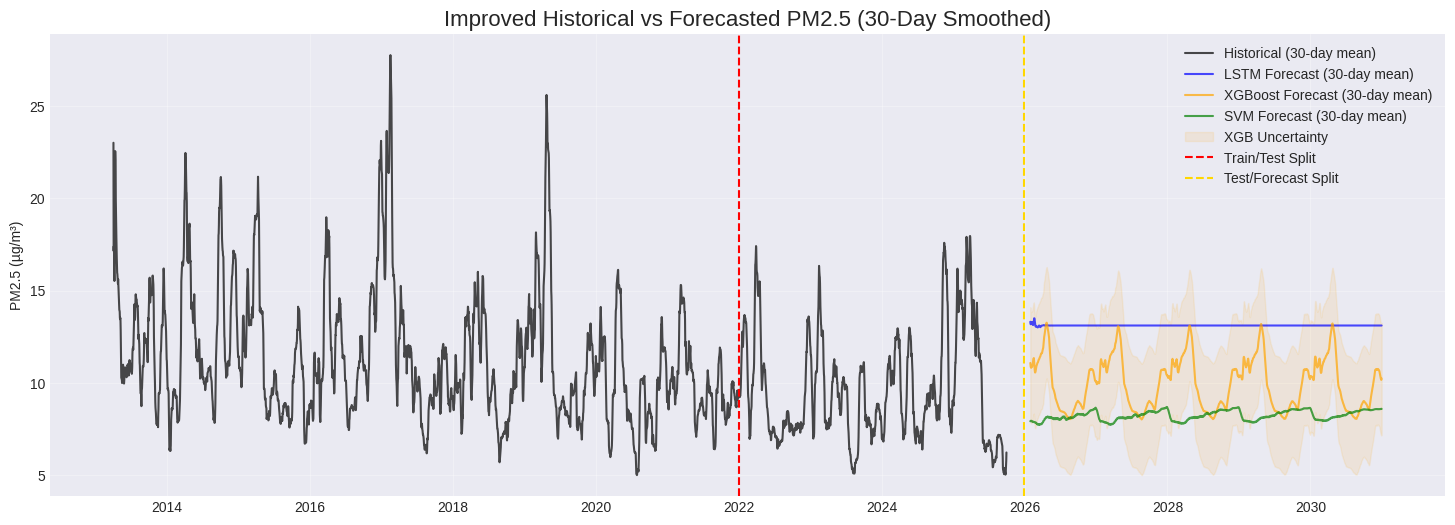

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))

# Historical smoothed
roll_hist = pm25_df['pm25'].rolling(30, min_periods=1).mean()
ax.plot(roll_hist, color='black', alpha=0.7, label='Historical (30-day mean)')

# Forecast smoothed (reduced thickness)
ax.plot(future_df['pm25_lstm'].rolling(30).mean(),
        color='blue', alpha=0.7, linewidth=1.5, label='LSTM Forecast (30-day mean)')
ax.plot(future_df['pm25_xgb'].rolling(30).mean(),
        color='orange', alpha=0.7, linewidth=1.5, label='XGBoost Forecast (30-day mean)')
ax.plot(future_df['pm25_svm'].rolling(30).mean(),
        color='green', alpha=0.7, linewidth=1.5, label='SVM Forecast (30-day mean)')

# Add uncertainty band for XGBoost (example: ± std of last year)
std = test['pm25'].rolling(90).std().iloc[-1]
future_mean = future_df['pm25_xgb'].rolling(30).mean()

ax.fill_between(future_mean.index, future_mean - std, future_mean + std,
                alpha=0.1, color='orange', label='XGB Uncertainty')

# Vertical boundaries
ax.axvline(pd.to_datetime('2021-12-31'), color='red', linestyle='--', label='Train/Test Split')
ax.axvline(pd.to_datetime('2025-12-31'), color='gold', linestyle='--', label='Test/Forecast Split')

ax.set_title('Improved Historical vs Forecasted PM2.5 (30-Day Smoothed)', fontsize=16)
ax.set_ylabel('PM2.5 (µg/m³)')
ax.legend()
ax.grid(alpha=0.3)

plt.show()


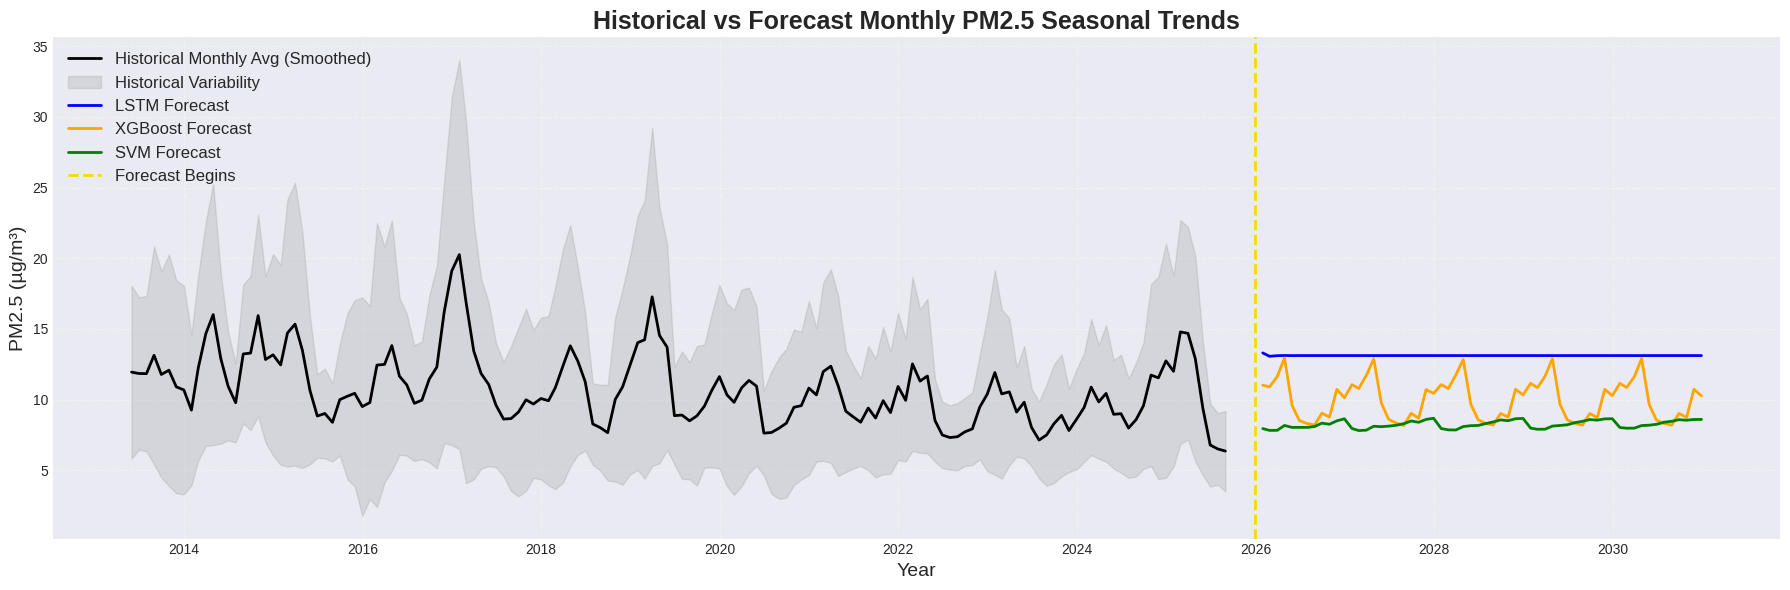

In [ ]:
# HISTORICAL VS FORECAST SEASONAL TRENDS

# Compute smoothed historical monthly averages
hist_monthly_mean = pm25_df['pm25'].resample('M').mean()
hist_monthly_std = pm25_df['pm25'].resample('M').std()

# Apply 3-month rolling mean for smoother seasonal trend
hist_monthly_smooth = hist_monthly_mean.rolling(3, center=True).mean()
hist_monthly_std_smooth = hist_monthly_std.rolling(3, center=True).mean()

# Forecast monthly averages
forecast_monthly = future_df[['pm25_lstm','pm25_xgb','pm25_svm']].resample('M').mean()

# Plot
fig, ax = plt.subplots(figsize=(18, 6))

# Historical SMOOTHED seasonal trend
ax.plot(hist_monthly_smooth.index, hist_monthly_smooth,
        label='Historical Monthly Avg (Smoothed)',
        color='black', linewidth=2)

# Historical variability shading (± 1 std)
ax.fill_between(hist_monthly_smooth.index,
                hist_monthly_smooth - hist_monthly_std_smooth,
                hist_monthly_smooth + hist_monthly_std_smooth,
                color='gray', alpha=0.2, label='Historical Variability')

# Forecast curves
ax.plot(forecast_monthly.index, forecast_monthly['pm25_lstm'],
        label='LSTM Forecast', color='blue', linewidth=2)

ax.plot(forecast_monthly.index, forecast_monthly['pm25_xgb'],
        label='XGBoost Forecast', color='orange', linewidth=2)

ax.plot(forecast_monthly.index, forecast_monthly['pm25_svm'],
        label='SVM Forecast', color='green', linewidth=2)

# Vertical line marking forecast start
ax.axvline(pd.to_datetime('2025-12-31'),
           color='gold', linestyle='--', linewidth=2, label='Forecast Begins')

# Titles and labels
ax.set_title('Historical vs Forecast Monthly PM2.5 Seasonal Trends', fontsize=18, fontweight='bold')
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)

# Grid for readability
ax.grid(axis='both', linestyle='--', alpha=0.3)

# Legend
ax.legend(fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()

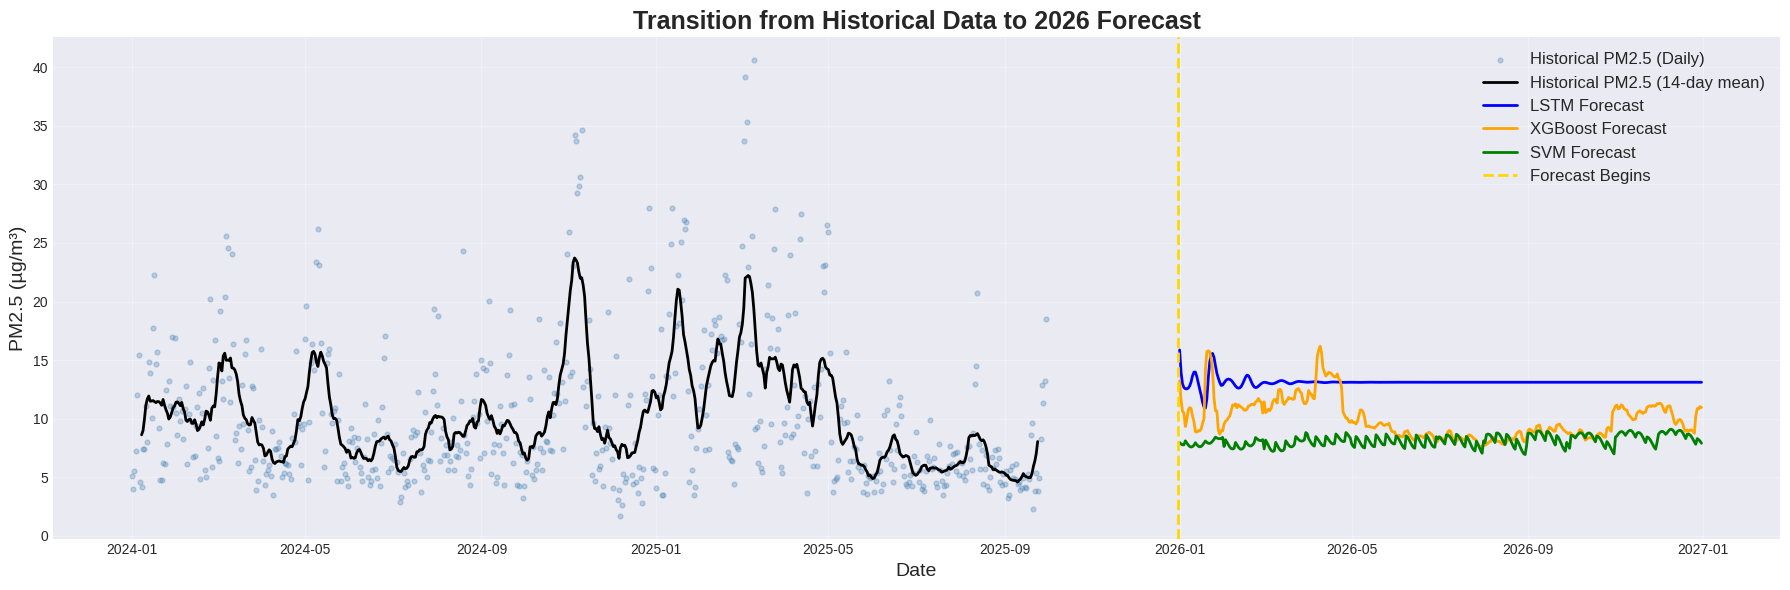

In [ ]:
# 2025 -> 2026 ZOOMED TRANSITION

zoom_hist = pm25_df.loc['2024':'2025']
zoom_smooth = zoom_hist['pm25'].rolling(14, center=True).mean()

zoom_forecast = future_df.loc['2026':'2026']

fig, ax = plt.subplots(figsize=(18,6))

# Raw historical scatter
ax.scatter(zoom_hist.index, zoom_hist['pm25'],
           label='Historical PM2.5 (Daily)',
           alpha=0.3, s=12, color='steelblue')

# Smoothed historical line
ax.plot(zoom_smooth.index, zoom_smooth,
        label='Historical PM2.5 (14-day mean)',
        color='black', linewidth=2)

# Forecast lines
ax.plot(zoom_forecast.index, zoom_forecast['pm25_lstm'],
        label='LSTM Forecast', color='blue', linewidth=2)

ax.plot(zoom_forecast.index, zoom_forecast['pm25_xgb'],
        label='XGBoost Forecast', color='orange', linewidth=2)

ax.plot(zoom_forecast.index, zoom_forecast['pm25_svm'],
        label='SVM Forecast', color='green', linewidth=2)

# Forecast boundary
ax.axvline(pd.to_datetime('2025-12-31'),
           color='gold', linestyle='--', linewidth=2, label='Forecast Begins')

# Titles + labels
ax.set_title('Transition from Historical Data to 2026 Forecast', fontsize=18, fontweight='bold')
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)

ax.grid(alpha=0.3)
ax.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()
